In [1]:
import scipy.io
import os
import shutil
try:
    from urllib import urlretrieve # python2
except:
    from urllib.request import urlretrieve # python3
from loss_csa import CSA

In [2]:
import data as data
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch
device = T.device("cuda")  # apply to Tensor or Module
import time
from tqdm import tqdm
from train_objectives import SAD, SID

In [3]:
torch.cuda.empty_cache()

In [4]:
mat = scipy.io.loadmat( 'PaviaU.mat' )
img = mat[ 'paviaU' ]

# create a hyperspectral dataset object from the numpy array
hypData = data.HypImg( img )

# pre-process data to make the model easier to train
hypData.pre_process( 'minmax' )

In [5]:
# create data iterator objects for training and validation using the pre-processed data
trainSamples = 200000
valSamples = 100
dataTrain = data.Iterator( dataSamples=hypData.spectraPrep[:trainSamples, :],
                        targets=hypData.spectraPrep[:trainSamples, :], batchSize=4 )
dataVal = data.Iterator( dataSamples=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :],
                        targets=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :] )


In [6]:
# shuffle training data
dataTrain.shuffle()

In [7]:
train_data = torch.tensor(dataTrain.dataSamples.astype(np.float32))
train_data

tensor([[1.8540e-01, 1.4144e-01, 1.3953e-01,  ..., 8.6353e-01, 8.7538e-01,
         9.0023e-01],
        [4.2105e-07, 8.8425e-03, 4.6316e-02,  ..., 3.5663e-01, 3.9790e-01,
         4.4800e-01],
        [1.1362e-01, 2.7387e-02, 3.7013e-03,  ..., 7.6499e-01, 7.8423e-01,
         7.9904e-01],
        ...,
        [5.9249e-02, 3.6127e-07, 3.6131e-03,  ..., 7.8360e-01, 7.9733e-01,
         8.0419e-01],
        [3.2108e-01, 3.0757e-01, 2.2973e-01,  ..., 8.7946e-01, 8.9514e-01,
         9.2919e-01],
        [3.1190e-01, 2.0699e-01, 1.1415e-01,  ..., 8.5531e-01, 8.5651e-01,
         8.6334e-01]])

In [8]:
hypData.numBands
encoderSize=[50,30,10]
encoderSize=[hypData.numBands]+encoderSize
decodersize=encoderSize[::-1]
encoderSize,decodersize

([103, 50, 30, 10], [10, 30, 50, 103])

In [9]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [10]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enn1 = T.nn.Linear(103, 50)  # 64-16-2-16-64
    self.enn2 = T.nn.Linear(50, 30)
    self.enn3 = T.nn.Linear(30,10)
    self.dnn3 = T.nn.Linear(10, 30)  # 64-16-2-16-64
    self.dnn2 = T.nn.Linear(30, 50)
    self.dnn1 = T.nn.Linear(50,103)

  def encoder(self,x):
    z= T.relu(self.enn1(x))
    z= T.relu(self.enn2(z))
    z= T.relu(self.enn3(z))
    return z
  
  def decoder(self,x):
    z= T.relu(self.dnn3(x))
    z= T.relu(self.dnn2(z))
    z= self.dnn1(z)
    return z


  def forward(self, x):
    encoded=self.encoder(x)
    decoded= self.decoder(encoded)
    
    return encoded,decoded
    
net=Net().to(device)


In [11]:

inpu=torch.rand(1,103).to(device)
outp=net(inpu)
outp[1].shape


torch.Size([1, 103])

In [12]:
hypData.numBands

103

In [13]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 8184
train_ldr = T.utils.data.DataLoader(train_data,
batch_size=bat_size, shuffle=True)
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 1300
ep_log_interval = 5
lrn_rate = 0.0001

loss_func1 = T.nn.MSELoss()
loss_func = CSA()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()


for epoch in range(0, max_epochs):
  time.sleep(0.5)
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0

  iterator = iter(train_ldr)
  
  for (batch_idx, batch) in loop:
    Z = next(iterator)
    Z = Z.view(Z.size()[0], -1)
    Z = Z.cuda()
    
    enc_out, dec_out = net(Z.float())
    loss1 = loss_func(dec_out, Z.float())  
    loss1 = torch.sum(loss1).float()
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    
    X = batch.to(device)  # no targets needed
    
    '''optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt[1], X)  # note: X not Y'''
    #loss_obj1=loss_func1(oupt[1],X)
    epoch_loss += loss1.item()  # accumulate
    #mseloss+=loss_obj1.item()
    #loss_obj.backward()
    #optimizer.step()
    
    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss))

    

  #if epoch % ep_log_interval == 0:
    
    
    #print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()






Begin UCI digits auto-reduce-viz demo job 

Creating 64-16-2-16-63 autoencoder 

bat_size = 8184 
loss = CSA()
optimizer = Adam
max_epochs = 1300 
lrn_rate = 0.000 

Starting training


Epoch [67/1300]: 100%|████████████████████████████████████████| 25/25 [00:01<00:00, 14.88it/s, loss=24.668266654014587]


Epoch [135/1300]: 100%|███████████████████████████████████████| 25/25 [00:01<00:00, 14.97it/s, loss=24.671022176742554]


Epoch [203/1300]: 100%|███████████████████████████████████████| 25/25 [00:01<00:00, 15.02it/s, loss=24.670706689357758]


Epoch [271/1300]: 100%|███████████████████████████████████████| 25/25 [00:01<00:00, 14.68it/s, loss=24.670510411262512]


Epoch [339/1300]: 100%|███████████████████████████████████████| 25/25 [00:01<00:00, 14.90it/s, loss=24.670373797416687]


Epoch [407/1300]: 100%|███████████████████████████████████████| 25/25 [00:01<00:00, 14.77it/s, loss=24.670140981674194]


Epoch [466/1300]:   4%|█▌                                      | 1/25 [00:00<00:03,  6.71it/s, loss=0.9874328970909119]


KeyboardInterrupt: 

In [18]:

torch.save(net, 'model_sad_2000.pth')

In [19]:
torch.save(net.state_dict(), 'net_model_sad.pth')

In [20]:
net.load_state_dict(torch.load('net_model_sad.pth'))

<All keys matched successfully>

In [21]:
trex=torch.tensor(hypData.spectraPrep.astype(np.float32))
trex

tensor([[0.1428, 0.1011, 0.0913,  ..., 0.8679, 0.8727, 0.8761],
        [0.1670, 0.1465, 0.1398,  ..., 0.8144, 0.8221, 0.8447],
        [0.2236, 0.2766, 0.1961,  ..., 0.9382, 0.9538, 0.9606],
        ...,
        [0.1139, 0.0292, 0.0460,  ..., 0.8492, 0.8594, 0.8660],
        [0.1068, 0.1744, 0.1333,  ..., 0.8415, 0.8397, 0.8316],
        [0.2278, 0.1603, 0.0520,  ..., 0.8381, 0.8505, 0.8657]])

In [22]:
dataZ=net.encoder(trex.to("cuda"))
dataZ

tensor([[0.7041, 0.0000, 0.0000,  ..., 1.1637, 0.0000, 3.2466],
        [0.7217, 0.0000, 0.0000,  ..., 1.3351, 0.0000, 3.3457],
        [0.7099, 0.0000, 0.0000,  ..., 1.3203, 0.0000, 3.2062],
        ...,
        [0.6689, 0.0000, 0.0000,  ..., 1.6667, 0.0000, 3.8806],
        [0.6299, 0.0000, 0.0000,  ..., 1.6903, 0.0000, 3.7466],
        [0.6034, 0.0000, 0.0000,  ..., 1.5922, 0.0000, 3.6888]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [23]:
dataY = net.decoder(dataZ)
dataY

tensor([[0.0475, 0.0423, 0.0361,  ..., 0.3087, 0.3098, 0.3121],
        [0.0570, 0.0556, 0.0530,  ..., 0.2958, 0.2966, 0.2981],
        [0.0876, 0.0736, 0.0585,  ..., 0.3058, 0.3068, 0.3097],
        ...,
        [0.0296, 0.0206, 0.0140,  ..., 0.2757, 0.2778, 0.2809],
        [0.0486, 0.0401, 0.0331,  ..., 0.2674, 0.2694, 0.2717],
        [0.0762, 0.0505, 0.0233,  ..., 0.2791, 0.2807, 0.2831]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [24]:
imgZ = np.reshape(dataZ.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [25]:
imgY = np.reshape(dataY.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [26]:
imgX = np.reshape(hypData.spectraPrep, (hypData.numRows, hypData.numCols, -1))

In [27]:
# visualise latent image using 3 out of the 10 dimensions
colourImg = imgZ.copy()
colourImg = colourImg[ :,:,np.argsort(-np.std(np.std(colourImg, axis=0), axis=0))[:3] ]
colourImg /= np.max(np.max(colourImg, axis=0), axis=0)

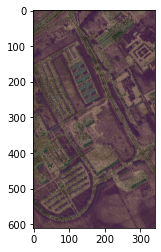

In [28]:
plt.imshow(colourImg)

Text(0.5, 1.0, 'meadow spectra')

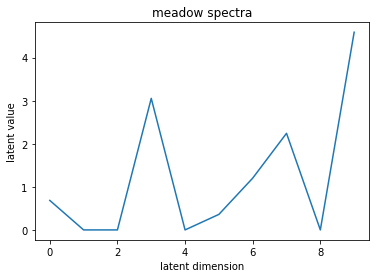

In [29]:
# save plot of latent vector of 'meadow' spectra
fig = plt.figure()
plt.plot(imgZ[576, 210, :])
plt.xlabel('latent dimension')
plt.ylabel('latent value')
plt.title('meadow spectra')

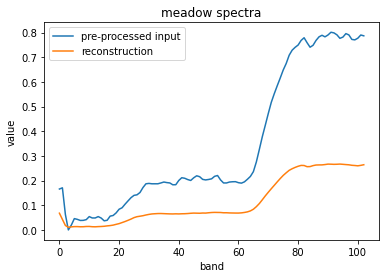

In [30]:
# save plot comparing pre-processed 'meadow' spectra input with decoder reconstruction
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(hypData.numBands),imgX[576, 210, :],label='pre-processed input')
ax.plot(range(hypData.numBands),imgY[576, 210, :],label='reconstruction')
plt.xlabel('band')
plt.ylabel('value')
plt.title('meadow spectra')
ax.legend()